##O objetivo deste EDA é verificar as falhas e deficiências da entrada do lead até a efetivação dos investimentos.

#Setup

##Configuração do Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


##Instalações

In [1]:
!pip install tensorflow==2.1.0

##Importação das bibliotecas

In [2]:
#Utils
import numpy as np
import pandas as pd
import datetime
#Scikit Learn
import sklearn
#Exibição na mesma tela do Jupyter
#Chart
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#TensorFlow
import tensorflow as tf
%load_ext tensorboard

##Inicialização dos DataSets

In [3]:
dfPerfil = pd.read_csv('lib/datasets/Dataset-1.csv', low_memory=False)
dfAcesso = pd.read_csv('lib/datasets/Dataset-2.csv', low_memory=False)
dfProduto = pd.read_csv('lib/datasets/Dataset-3.csv', low_memory=False)

##Funções

In [4]:
def removeOutlierByQuartiles(dataFrame, columnName, inplace = True):

  Q1 = dataFrame[columnName].quantile(0.25)
  Q3 = dataFrame[columnName].quantile(0.75)
  IQR = Q3 - Q1

  outliers = dataFrame[columnName][~((dataFrame[columnName] > (Q1 - 1.5 * IQR)) & (dataFrame[columnName] < (Q3 + 1.5 * IQR)))]
  dataFrame.drop(index=outliers.index, inplace=inplace)

def getProdutoId(dictProducts, searchName=''):
  for key, value in dictProducts.items():
    if value == searchName.lower():
      return key
  return 0

def getProdutoIdFromOneHotEncoded(dictProducts, dictProductsOneHotEncoded, seachOneHotEncodedId):
  for key, value in dictProductsOneHotEncoded.items():
    if value == seachOneHotEncodedId:
      return dictProductsOneHotEncoded[key]
  return 0

def getOneHotEncodedByProdutcName(dictProducts, dictProductsOneHotEncoded, seachProductName):
  for key, value in dictProducts.items():
    if value == seachProductName.lower():
      return dictProductsOneHotEncoded[key]
  return 0

#Dataset Perfil - Exploração inicial

##Amostra

In [ ]:
dfPerfil.head()

,Unnamed: 0,Id,Idade,EstadoCivil,BillingCity,NivelConhecimentoAtual,ScoreNivelConhecimento,PerfilInvestidor,RendaMensal,ValorPatrimonio,Pergunta1,Resposta11,Pergunta2,Resposta21,Pergunta3,Resposta31,Pergunta4,Resposta41,Pergunta5,Resposta51,Resposta52,Resposta53,Resposta54,Resposta55,Resposta56,Resposta57,Resposta58,Pergunta6,Resposta61,Resposta62,Resposta63,Resposta64,Resposta65,Resposta66,Resposta67,Resposta68,Pergunta7,Resposta71,Resposta72,Resposta73,Resposta74,Resposta75,Pergunta8,Resposta81,Pergunta9,Resposta91,ScoreRisco,ScoreObjetivos,ScoreSituacaoFinanceira,Produto,NomeDoProduto,NomeEmissor,TaxaCliente,TaxaPreCliente,DescricaoProduto,ValorMinimoAplicaInicial,ValorMinimoAplicacaoAdicional,DataVencimento,FamiliaCarteira,ValorInvestidoAtual,ValorRendimento,Rentabilidade12Meses,RentabilidadeMes,RiscoAtivo,Status,ProdutoId
25372,25372,$2b$10$.DCvvJ9WSDpqVP2xXjeSPeE.IZI/Zbya54LSa8D...,25,S,São Paulo,5.0,5.0,4,4500.0,NaN,Por quanto tempo você pretende manter seu dinh...,De 1 a 5 anos,Quando pensa em investimento o que vem primeir...,"Multiplicar meu dinheiro, com a possibilidade ...","Dos seus investimentos, qual a necessidade de ...",Até 30%,Agora imagine que você fez um investimento de ...,Mantenho como está,Quais desses produtos você já investiu nos últ...,NaN,NaN,"CDB, LCA e LCI",NaN,NaN,Fundos Multimercado,Ações,NaN,Quais desses produtos você conseguiria explica...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Agora nos conte como seu dinheiro está distrib...,NaN,NaN,Previdência,Fundos de investimento,Ações e derivativos,Quanto da sua renda mensal você consegue guard...,Menor ou igual a 20% da minha renda,Tem alguma formação ou experiência que envolve...,Tenho formação e experiência,4.0,4.0,3.0,a0W6A000009agwtUAA,VOTORANTIM FI EQUITY HEDGE MULTIMERCADO,NaN,NaN,NaN,VOTORANTIM FI EQUITY HEDGE MULTIMERCADO,5000.0,1000.0,NaN,Renda Fixa,7000.00,NaN,7.146242,0.5892906,3.0,Efetivada,a0W6A000009agwtUAA
7521,7521,$2b$10$.DCvvJ9WSDpqVP2xXjeSPerlS48fSek8erzqmun...,43,C,Osasco,2.0,2.0,4,1500.0,20000.0,Por quanto tempo você pretende manter seu dinh...,Acima de 5 anos,Quando pensa em investimento o que vem primeir...,"Multiplicar meu dinheiro, com a possibilidade ...","Dos seus investimentos, qual a necessidade de ...",Não preciso,Agora imagine que você fez um investimento de ...,Mantenho como está,Quais desses produtos você já investiu nos últ...,Poupança,Tesouro Direto,NaN,NaN,NaN,NaN,NaN,NaN,Quais desses produtos você conseguiria explica...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Agora nos conte como seu dinheiro está distrib...,Poupança,NaN,NaN,NaN,NaN,Quanto da sua renda mensal você consegue guard...,Menor ou igual a 50% da minha renda,Tem alguma formação ou experiência que envolve...,Não tenho,4.0,5.0,3.0,a0W6A000009L0FgUAK,RENATO SANTANIELLO - SANTANDER PRIVATE,NaN,NaN,NaN,RENATO SANTANIELLO - SANTANDER PRIVATE,30.0,30.0,NaN,Renda Fixa,30.00,NaN,0.000000,0.55975825,4.0,Efetivada,a0W6A000009L0FgUAK
32204,32204,$2b$10$.DCvvJ9WSDpqVP2xXjeSPeRf2ftOZOoaGQdJex1...,52,C,São Paulo,4.0,3.0,4,8000.0,500000.0,Por quanto tempo você pretende manter seu dinh...,Acima de 5 anos,Quando pensa em investimento o que vem primeir...,Acumular dinheiro com baixo risco,"Dos seus investimentos, qual a necessidade de ...",Até 30%,Agora imagine que você fez um investimento de ...,Mantenho como está,Quais desses produtos você já investiu nos últ...,Poupança,Tesouro Direto,"CDB, LCA e LCI",NaN,NaN,NaN,Ações,NaN,Quais desses produtos você conseguiria explica...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Agora nos conte como seu dinheiro está distrib...,Poupança,"Renda FIxa (CDB, LCA...)",Previdência,NaN,Ações e derivativos,Quanto da sua renda mensal você consegue guard...,Menor ou igual a 20% da minha renda,Tem alguma formação ou experiência que envolve...,Não tenho,2.0,3.0,2.0,a0W6A000009R6mvUAC,JOJO WACHSMANN - VITREO,NaN,NaN,NaN,LIBERDADE TOTAL-VITREO,1000.0,100.0,NaN,Renda Fixa,49999.99,NaN,0.000000,0.91971882,4.0,Efetivada,a0W6A000009R6mvUAC
12150,12150,$2b$10$.DCvvJ9WSDpqVP2xXjeSPeu

##Descritivo

In [ ]:
dfPerfil.describe()

,Unnamed: 0,Idade,NivelConhecimentoAtual,ScoreNivelConhecimento,PerfilInvestidor,RendaMensal,ValorPatrimonio,ScoreRisco,ScoreObjetivos,ScoreSituacaoFinanceira,TaxaCliente,TaxaPreCliente,ValorMinimoAplicaInicial,ValorMinimoAplicacaoAdicional,ValorInvestidoAtual,ValorRendimento,Rentabilidade12Meses,RiscoAtivo
count,1000.000000,1000.000000,915.000000,987.000000,1000.000000,1.000000e+03,6.810000e+02,987.000000,987.000000,987.000000,139.000000,139.000000,589.000000,827.000000,964.000000,133.000000,825.000000,964.000000
mean,19518.927000,37.223000,2.568306,2.602837,2.863000,1.096822e+04,7.690439e+05,2.717325,3.225937,2.114488,96.093525,0.523597,843.701188,357.921451,4086.016266,152.693083,10.433262,2.624481
std,10932.012462,11.377289,1.547385,1.537995,1.109713,7.708588e+04,1.833705e+06,1.099573,1.170382,0.968082,28.458689,2.027921,2866.500845,900.687711,15818.644483,343.553178,19.295673,1.547470
min,27.000000,18.000000,1.000000,1.000000,0.000000,0.000000e+00,1.000000e+00,1.000000,1.000000,1.000000,0.000000,0.000000,30.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,9930.500000,29.000000,1.000000,1.000000,2.000000,2.000000e+03,4.000000e+04,2.000000,2.000000,1.000000,94.000000,0.000000,30.000000,30.000000,50.000000,4.870000,0.000000,1.000000
50%,19779.000000,36.000000,2.000000,2.000000,3.000000,4.417285e+03,2.500000e+05,3.000000,3.000000,2.000000,100.000000,0.000000,30.000000,30.000000,300.000000,33.050000,0.000000,2.000000
75%,28808.250000,43.000000,4.000000,4.000000,4.000000,1.000000e+04,8.000000e+05,4.000000,4.000000,3.000000,111.500000,0.000000,500.000000,100.000000,3000.000000,159.240000,11.402803,4.000000
max,38003.000000,82.000000,5.000000,5.000000,5.000000,2.400000e+06,3.000000e+07,5.000000,5.000000,5.000000,125.000000,12.000000,50000.000000,10000.000000,268000.000000,3177.110000,100.378999,5.000000


In [ ]:
dfPerfil.NomeDoProduto.unique()

array(['PI SELIC RF SIMPLES FI', 'JOJO WACHSMANN - VITREO',
       'SAM JURO REAL RF FIC FI',
       'RENATO SANTANIELLO - SANTANDER PRIVATE',
       'SAM RENDA FIXA LONGO PRAZO FIC FI', 'FABIO PASSOS - CA INDOSUEZ',
       'DAN KAWA - TAG INVESTIMENTOS',
       'BERNARDO S. DA ICATU - DATA ALVO 2030', 'CDB', 'LCA',
       'TRIGONO FLAGSHIP SMALL CAPS FIC FIA', 'BOGARI VALUE D FIC FIA',
       'LCI', 'BERNARDO S. DA ICATU - DATA ALVO 2040',
       'BTG PACTUAL YIELD DI FI REFERENCIADO CP',
       'ALASKA BLACK FIC FIA II - BDR NÍVEL I',
       'ICATU VANGUARDA CP FIRF LP',
       'SAM RATES AND FX MULTIMERCADO FIC FI', 'SUL AMÉRICA FV FIA', 'LC',
       'NEST FIA', 'KADIMA EQUITIES FIC FIA', 'CONSTÂNCIA FUNDAMENTO FIA',
       'BERNARDO S. DA ICATU - DATA ALVO 2050', 'ARX INCOME FIA',
       'EQUITAS SELECTION FIC FIA',
       'EQUITAS SELECTION MÃO AMIGA FIC AÇÕES',
       'AZ QUEST YIELD FIC FIRF LP', 'ARX FIA',
       'IBIUNA EQUITIES 30 FIC FIA', 'KAPITALO KAPPA D FIC FIM',
       

##Observações

*   Há valores nulos no DataSet Perfil
*   Não há informações de acessos



#Dataset Acesso - Exploração inicial

##Amostra

In [ ]:
dfAcesso.head()

,Unnamed: 0,Id,page_path,pageviews
333500,333500,NaN,/s/,6
300237,300237,$2b$10$.DCvvJ9WSDpqVP2xXjeSPesQi1yBanLOzzQbjpF...,/s/vitrine?secao=novos,1
236173,236173,NaN,/s/produtos/a0W6A000009L0FgUAK/RENATO SANTINEL...,0
1558,1558,NaN,/s/produtos/a0W3u00000AdOBNEA3/BERNARDO S. DA ...,0
283848,283848,NaN,/s/produtos/a0W6A000009GZdgUAG/pi-selic-rf-sim...,1


##Descritivo

In [ ]:
dfAcesso.describe()

,Unnamed: 0,pageviews
count,382937.000000,382937.000000
mean,191468.000000,1.870642
std,110544.534354,3.529426
min,0.000000,0.000000
25%,95734.000000,1.000000
50%,191468.000000,1.000000
75%,287202.000000,2.000000
max,382936.000000,287.000000


##Observações

*   A coluna ID contém um GUID que contém NaN
*   A coluna page_path contém a URL da página a partir da home, porém há páginas com query string que será necessária limpeza para estudo



#Dataset Produto - Exploração inicial

##Amostra

In [ ]:
dfProduto.head()

,Unnamed: 0,AdministradorFundo__c,AtivoDisponivel__c,Carencia__c,CarteiraCNPJ__c,CNPJAdministrador__c,DataDeVencimento__c,DescontoIR__c,DescricaoAtivo__c,DescricaoCarencia__c,DescricaoClasse__c,DescricaoCotizacaoAplicacao__c,DescricaoCotizacaoResgate__c,DescricaoEmissor__c,DescricaoIndexador__c,DescricaoIndiceBenchmark__c,DescricaoLiquidacaoAplicacao__c,DescricaoLiquidacaoResgate__c,DescricaoProduto__c,DescricaoTaxaPerformance__c,DescricaoTributacaoProduto__c,DescricaoTributacao__c,DiasUteisParaResgate__c,DiasVencimento__c,FamiliaCarteira__c,FiltroValorMinimo__c,GestorFundo__c,ProdutoId,Inativo__c,LucroMesAnterior__c,NDiasCotizacaoAplicacao__c,NomeAdministrador__c,NomeCompleto__c,NomeEmissor__c,NomeIndexador__c,NomeInvestimento__c,NomeProduto__c,Nome__c,NrDiasUteisCotizacaoResgate__c,NrDiasUteisLiqFAplicacao__c,...,QuantidadeAvaliacoes__c,QuantidadeConsumida__c,Rentabilidade12Meses__c,RentabilidadeAno__c,RentabilidadeFundoUltimos36Meses__c,RentabilidadeIndiceBenchmarkAno__c,RentabilidadeIndiceBenchmarkMes__c,RentabilidadeIndiceBenchmarkUlt12__c,RentabilidadeIndiceBenchmarkUlt36__c,RentabilidadeInicioFundo__c,RentabilidadeMes__c,RentabilidadeUltimos12Meses__c,ResgateDias__c,RiscoAtivo__c,SaldoMinimoPermanencia__c,SeFGCAtivo__c,SeIRAtivo__c,StatusCarteira__c,Status__c,TaxaAdministracaoFixa__c,TaxaAdministracaoMaxima__c,TaxaAdministracaoMinima__c,TaxaAdm__c,TaxaCliente__c,TaxaEmissao__c,TaxaNegociada360__c,TaxaPerformance__c,TaxaPreCliente__c,TaxaPreEmissao__c,Taxa__c,TipoCarteira__c,TipoCota__c,TipoIndexador__c,TipoRegimeCondomonioCVM__c,Tributacao__c,ValorMinimoAplicacaoAdicional__c,ValorMinimoAplicaInicial__c,ValorMinimoResgate__c,ValorMinimo__c,Vencimento__c
0,0,NaN,False,2020-11-16,NaN,NaN,2020-11-16,20.0,"O Certificado de Dep�sito Banc�rio, de forma s...",No venc.,PRIVADO,No dia,No dia,BANCO BMG S.A.,IPCA,NaN,No dia,No dia,CDB POS 1,NaN,NaN,15%,NaN,283.0,NaN,5000.0,NaN,a0W3u000009PBddEAG,False,NaN,NaN,NaN,NaN,BANCO BMG S.A.,+ IPCA,CDB,CDB POS 1,NaN,NaN,NaN,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No venc.,0.0,NaN,True,True,NaN,NaN,NaN,NaN,NaN,NaN,100.0,100.0,0.0,NaN,0.90,1.10,0.0,NaN,NaN,IPCA,NaN,NaN,NaN,NaN,NaN,5000.0,2020-11-16
1,1,NaN,False,2021-11-16,NaN,NaN,2021-11-16,17.5,"O Certificado de Dep�sito Banc�rio, de forma s...",No venc.,PRIVADO,No dia,No dia,BANCO BMG S.A.,IPCA,NaN,No dia,No dia,CDB POS 1,NaN,NaN,15%,NaN,648.0,NaN,5000.0,NaN,a0W3u000009PBdeEAG,False,NaN,NaN,NaN,NaN,BANCO BMG S.A.,+ IPCA,CDB,CDB POS 1,NaN,NaN,NaN,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No venc.,0.0,NaN,True,True,NaN,NaN,NaN,NaN,NaN,NaN,100.0,100.0,0.0,NaN,1.21,1.41,0.0,NaN,NaN,IPCA,NaN,NaN,NaN,NaN,NaN,5000.0,2021-11-16
2,2,NaN,False,2022-11-16,NaN,NaN,2022-11-16,15.0,"O Certificado de Dep�sito Banc�rio, de forma s...",No venc.,PRIVADO,No dia,No dia,BANCO BMG S.A.,IPCA,NaN,No dia,No dia,CDB POS 1,NaN,NaN,15%,NaN,1013.0,NaN,5000.0,NaN,a0W3u000009PBdfEAG,False,NaN,NaN,NaN,NaN,BANCO BMG S.A.,+ IPCA,CDB,CDB POS 1,NaN,NaN,NaN,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No venc.,0.0,NaN,True,True,NaN,NaN,NaN,NaN,NaN,NaN,100.0,100.0,0.0,NaN,2.04,2.24,0.0,NaN,NaN,IPCA,NaN,NaN,NaN,NaN,NaN,5000.0,2022-11-16
3,3,NaN,False,2024-11-18,NaN,NaN,2024-11-18,15.0,"O Certificado de Dep�sito Banc�rio, de forma s...",No venc.,PRIVADO,No dia,No dia,BANCO BMG S.A.,IPCA,NaN,No dia,No dia,CDB POS 1,NaN,NaN,15%,NaN,1746.0,NaN,5000.0,NaN,a0W3u000009PBdgEAG,False,NaN,NaN,NaN,NaN,BANCO BMG S.A.,+ IPCA,CDB,CDB POS 1,NaN,NaN,NaN,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No venc.,0.0,NaN,True,True,NaN,NaN,NaN,NaN,NaN,NaN,100.0,100.0,0.0,NaN,2.89,3.09,0.0,NaN,NaN,IPCA,NaN,NaN,NaN,NaN,NaN,5000.0,2024-11-18
4,4,NaN,False,2020-11-03,NaN,NaN,2020-11-03,20.0,"O Certificado de Dep�sito Banc�rio, de forma s...",No venc.,PRIVADO,No dia,No dia,BANCO BMG S.A.,PRE,NaN,No dia,No dia,CDB PRE 1,NaN,NaN,15%,NaN,270.0,NaN,5000.0,NaN,a0W3u000009PBdhEAG,False,NaN,NaN,NaN,NaN,BANCO BMG S.A.,PRÉ,CDB,CDB PRE 1,NaN,NaN,NaN,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,

In [ ]:
dfProduto.describe()

,Unnamed: 0,DescontoIR__c,DiasVencimento__c,FiltroValorMinimo__c,LucroMesAnterior__c,NDiasCotizacaoAplicacao__c,NrDiasUteisCotizacaoResgate__c,NrDiasUteisLiqFAplicacao__c,NrDiasUteisLiqFResgate__c,PatrimonioLiquidoAtual__c,PercentualIndexador__c,PrazoCarencia__c,PrazoDias__c,PrecoUnitario__c,QuantidadeAvaliacoes__c,QuantidadeConsumida__c,Rentabilidade12Meses__c,RentabilidadeAno__c,RentabilidadeFundoUltimos36Meses__c,RentabilidadeIndiceBenchmarkAno__c,RentabilidadeIndiceBenchmarkMes__c,RentabilidadeIndiceBenchmarkUlt12__c,RentabilidadeIndiceBenchmarkUlt36__c,RentabilidadeInicioFundo__c,RentabilidadeMes__c,RentabilidadeUltimos12Meses__c,RiscoAtivo__c,SaldoMinimoPermanencia__c,Status__c,TaxaAdministracaoFixa__c,TaxaAdministracaoMaxima__c,TaxaAdministracaoMinima__c,TaxaAdm__c,TaxaCliente__c,TaxaEmissao__c,TaxaNegociada360__c,TaxaPerformance__c,TaxaPreCliente__c,TaxaPreEmissao__c,Taxa__c,ValorMinimoAplicacaoAdicional__c,ValorMinimoAplicaInicial__c,ValorMinimoResgate__c,ValorMinimo__c
count,8603.000000,8603.000000,8282.000000,8603.000000,320.000000,320.000000,320.000000,320.0,320.000000,3.200000e+02,8282.0,8282.000000,8282.000000,8282.000000,8603.000000,8281.000000,320.000000,320.000000,320.000000,320.0,320.0,320.0,320.0,320.000000,320.000000,320.000000,8602.000000,320.000000,0.0,320.000000,320.000000,320.000000,0.0,8282.000000,8282.000000,8282.0,0.0,8282.000000,8282.000000,8282.0,320.000000,320.000000,320.000000,8282.000000
mean,4301.000000,17.279437,858.665902,5781.588051,1.890720,0.390625,22.121875,0.0,1.540625,5.894390e+08,0.0,954.205868,957.771553,918.765040,0.000232,0.014129,19.006168,2.730782,43.706340,0.0,0.0,0.0,0.0,310.584543,0.859417,18.359419,0.806440,4111.425000,NaN,0.437906,1.438500,1.069531,NaN,36.932103,37.163605,0.0,NaN,5.104583,5.389063,0.0,2607.675000,6775.468750,2435.800000,5743.884569
std,2483.616516,2.606157,570.948565,11837.216847,18.521884,0.488655,17.729794,0.0,0.720223,1.209156e+09,0.0,535.925224,566.022127,10989.483362,0.015246,1.105506,35.176629,18.541050,49.945488,0.0,0.0,0.0,0.0,746.852271,1.023248,34.998309,1.529188,5328.133627,NaN,0.760715,1.150598,0.909107,NaN,49.497238,49.820761,0.0,NaN,4.026771,11.667128,0.0,3616.864216,8598.930445,3155.308798,11944.003587
min,0.000000,15.000000,-1.000000,0.000000,-18.366811,0.000000,0.000000,0.0,0.000000,0.000000e+00,0.0,0.000000,0.000000,0.010000,0.000000,0.000000,-4.470635,-17.881317,-14.470798,0.0,0.0,0.0,0.0,-84.466093,-3.128142,-3.134018,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.0,NaN,0.000000,0.000000,0.0,0.000000,30.000000,0.000000,1.000000
25%,2150.500000,15.000000,361.000000,1000.000000,0.054150,0.000000,3.000000,0.0,1.000000,6.793882e+07,0.0,392.000000,396.000000,1000.000000,0.000000,0.000000,5.901180,0.398166,0.000000,0.0,0.0,0.0,0.0,34.184918,0.060368,5.844433,0.000000,1000.000000,NaN,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.0,NaN,3.150000,3.350000,0.0,500.000000,1000.000000,500.000000,1000.000000
50%,4301.000000,17.500000,719.000000,5000.000000,0.476561,0.000000,30.000000,0.0,1.000000,2.025237e+08,0.0,748.500000,749.000000,1000.000000,0.000000,0.000000,10.588899,0.710064,26.470027,0.0,0.0,0.0,0.0,116.286335,0.482512,10.325942,0.000000,1000.000000,NaN,0.000000,1.665000,1.000000,NaN,0.000000,0.000000,0.0,NaN,5.700000,5.900000,0.0,1000.000000,5000.000000,1000.000000,5000.000000
75%,6451.500000,20.000000,1249.000000,10000.000000,1.345336,1.000000,30.000000,0.0,2.000000,6.523775e+08,0.0,1440.000000,1440.000000,1000.000000,0.000000,0.000000,27.411678,2.955103,78.601755,0.0,0.0,0.0,0.0,253.648618,1.721036,26.720782,0.000000,5000.000000,NaN,0.512500,2.500000,1.950000,NaN,100.000000,100.000000,0.0,NaN,7.007500,7.197500,0.0,5000.000000,10000.000000,5000.000000,10000.000000
max,8602.000000,22.500000,17898.000000,1000000.000000,328.808151,1.000000,90.000000,0.0,5.000000,1.404355e+10,0.0,2557.000000,18000.000000,1000000.000000,1.000000,100.000000,584.324863,329.029149,348.519414,0.0,0.0,0.0,0.0,7090.954249,3.689640,585.8054

In [ ]:
dfProduto['TipoIndexador__c'].unique()

array(['IPCA', 'Pré fixado', nan, 'CDI', 'IGPM'], dtype=object)

In [ ]:
dfProduto['NomeIndexador__c'].unique()

array(['+ IPCA', 'PRÉ', nan, 'CDI', '+IGPM', '+ CDI'], dtype=object)

In [ ]:
dfProduto['NomeProduto__c'].unique()

array(['CDB POS 1', 'CDB PRE 1', 'CDB POS', 'CDB PRE', 'LCA PRE',
       'LCI PRE', nan, 'LC POS', 'LCI POS 1', 'LCA POS', 'LCA POS 1',
       'LCI POS', 'LC PRE', 'LCI PRE 1', 'CDI POS', 'Gabriel',
       'CDB POS SAN', 'LCI POS SAN'], dtype=object)

In [ ]:
dfProduto['DescricaoProduto__c'].unique()

array(['CDB POS 1', 'CDB PRE 1', 'CDB POS', 'CDB PRE', 'LCA PRE',
       'LCI PRE', nan, 'LC POS', 'LCI POS 1', 'LCA POS', 'LCA POS 1',
       'LCI POS', 'LC PRE', 'LCI PRE 1', 'CDI POS', 'CDB POS SAN',
       'LCI POS SAN'], dtype=object)

In [ ]:
dfProduto['NomeInvestimento__c'].unique()

array(['CDB', 'LCA', 'LCI', 'EQUITAS SELECTION MÃO AMIGA FIC AÇÕES',
       'EQUITAS SELECTION FIC FIA', 'LC',
       'TRIGONO FLAGSHIP SMALL CAPS FIC FIA', 'TRIGONO VERBIER  FIA',
       'SQUADRA LONG-BIASED FIC FIA', 'SQUADRA LONG-ONLY FIC FIA',
       'BOGARI VALUE D FIC FIA', 'KIRON FIC FIA',
       'KIRON INSTITUCIONAL FIA', 'KAPITALO ALPHA GLOBAL FIC FIM',
       'KAPITALO KAPPA D FIC FIM', 'KAPITALO TARKUS FIC FIA',
       'FRANKLIN K2 ALTERNATIVE STRATEGIES FIC F',
       'FRANKLIN VALOR E LIQUIDEZ FVL FIC FIA',
       'PORTO SEGURO ALOCAÇÃO FIC FIM', 'PORTO SEGURO MACRO FIC FIM',
       'PORTO SEGURO CLÁSSICO RF FICFI LP',
       'PORTO SEGURO IMA-B5 FIC DE FI RF LP',
       'PORTO SEGURO SELECTA FIC FIA',
       'PORTO SEGURO FI RF REF DI CREDITO PRIVAD',
       'PORTO SEGURO JURO REAL FIC FI RF LP',
       'REACH FUNDO DE INVESTIMENTO DE ACOES',
       'REACH TOTAL RETURN FIC FIA', 'DLM HEDGE CONSERVADOR II FIRF CP',
       'PERFIN FORESIGHT INSTITUCIONAL FIC FIA',
       'P

##Descritivo

In [ ]:
dfProduto.describe()

,Unnamed: 0,DescontoIR__c,DiasVencimento__c,FiltroValorMinimo__c,LucroMesAnterior__c,NDiasCotizacaoAplicacao__c,NrDiasUteisCotizacaoResgate__c,NrDiasUteisLiqFAplicacao__c,NrDiasUteisLiqFResgate__c,PatrimonioLiquidoAtual__c,PercentualIndexador__c,PrazoCarencia__c,PrazoDias__c,PrecoUnitario__c,QuantidadeAvaliacoes__c,QuantidadeConsumida__c,Rentabilidade12Meses__c,RentabilidadeAno__c,RentabilidadeFundoUltimos36Meses__c,RentabilidadeIndiceBenchmarkAno__c,RentabilidadeIndiceBenchmarkMes__c,RentabilidadeIndiceBenchmarkUlt12__c,RentabilidadeIndiceBenchmarkUlt36__c,RentabilidadeInicioFundo__c,RentabilidadeMes__c,RentabilidadeUltimos12Meses__c,RiscoAtivo__c,SaldoMinimoPermanencia__c,Status__c,TaxaAdministracaoFixa__c,TaxaAdministracaoMaxima__c,TaxaAdministracaoMinima__c,TaxaAdm__c,TaxaCliente__c,TaxaEmissao__c,TaxaNegociada360__c,TaxaPerformance__c,TaxaPreCliente__c,TaxaPreEmissao__c,Taxa__c,ValorMinimoAplicacaoAdicional__c,ValorMinimoAplicaInicial__c,ValorMinimoResgate__c,ValorMinimo__c
count,8603.000000,8603.000000,8282.000000,8603.000000,320.000000,320.000000,320.000000,320.0,320.000000,3.200000e+02,8282.0,8282.000000,8282.000000,8282.000000,8603.000000,8281.000000,320.000000,320.000000,320.000000,320.0,320.0,320.0,320.0,320.000000,320.000000,320.000000,8602.000000,320.000000,0.0,320.000000,320.000000,320.000000,0.0,8282.000000,8282.000000,8282.0,0.0,8282.000000,8282.000000,8282.0,320.000000,320.000000,320.000000,8282.000000
mean,4301.000000,17.279437,858.665902,5781.588051,1.890720,0.390625,22.121875,0.0,1.540625,5.894390e+08,0.0,954.205868,957.771553,918.765040,0.000232,0.014129,19.006168,2.730782,43.706340,0.0,0.0,0.0,0.0,310.584543,0.859417,18.359419,0.806440,4111.425000,NaN,0.437906,1.438500,1.069531,NaN,36.932103,37.163605,0.0,NaN,5.104583,5.389063,0.0,2607.675000,6775.468750,2435.800000,5743.884569
std,2483.616516,2.606157,570.948565,11837.216847,18.521884,0.488655,17.729794,0.0,0.720223,1.209156e+09,0.0,535.925224,566.022127,10989.483362,0.015246,1.105506,35.176629,18.541050,49.945488,0.0,0.0,0.0,0.0,746.852271,1.023248,34.998309,1.529188,5328.133627,NaN,0.760715,1.150598,0.909107,NaN,49.497238,49.820761,0.0,NaN,4.026771,11.667128,0.0,3616.864216,8598.930445,3155.308798,11944.003587
min,0.000000,15.000000,-1.000000,0.000000,-18.366811,0.000000,0.000000,0.0,0.000000,0.000000e+00,0.0,0.000000,0.000000,0.010000,0.000000,0.000000,-4.470635,-17.881317,-14.470798,0.0,0.0,0.0,0.0,-84.466093,-3.128142,-3.134018,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.0,NaN,0.000000,0.000000,0.0,0.000000,30.000000,0.000000,1.000000
25%,2150.500000,15.000000,361.000000,1000.000000,0.054150,0.000000,3.000000,0.0,1.000000,6.793882e+07,0.0,392.000000,396.000000,1000.000000,0.000000,0.000000,5.901180,0.398166,0.000000,0.0,0.0,0.0,0.0,34.184918,0.060368,5.844433,0.000000,1000.000000,NaN,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.0,NaN,3.150000,3.350000,0.0,500.000000,1000.000000,500.000000,1000.000000
50%,4301.000000,17.500000,719.000000,5000.000000,0.476561,0.000000,30.000000,0.0,1.000000,2.025237e+08,0.0,748.500000,749.000000,1000.000000,0.000000,0.000000,10.588899,0.710064,26.470027,0.0,0.0,0.0,0.0,116.286335,0.482512,10.325942,0.000000,1000.000000,NaN,0.000000,1.665000,1.000000,NaN,0.000000,0.000000,0.0,NaN,5.700000,5.900000,0.0,1000.000000,5000.000000,1000.000000,5000.000000
75%,6451.500000,20.000000,1249.000000,10000.000000,1.345336,1.000000,30.000000,0.0,2.000000,6.523775e+08,0.0,1440.000000,1440.000000,1000.000000,0.000000,0.000000,27.411678,2.955103,78.601755,0.0,0.0,0.0,0.0,253.648618,1.721036,26.720782,0.000000,5000.000000,NaN,0.512500,2.500000,1.950000,NaN,100.000000,100.000000,0.0,NaN,7.007500,7.197500,0.0,5000.000000,10000.000000,5000.000000,10000.000000
max,8602.000000,22.500000,17898.000000,1000000.000000,328.808151,1.000000,90.000000,0.0,5.000000,1.404355e+10,0.0,2557.000000,18000.000000,1000000.000000,1.000000,100.000000,584.324863,329.029149,348.519414,0.0,0.0,0.0,0.0,7090.954249,3.689640,585.8054

##Observações

#Hipóteses

##Há perda de usuários no preenchimento do perfil principal e o suitability?

Busca dos links de interesse

In [ ]:
#SelfRegister -> Tela inicial do cadastro
#cadastroprincipal -> Questionário pessoal
#suitability -> Questionário do perfil do investidor
#s -> Página inicial após login

verificarAcessosCadastro = lambda i: 'SelfRegister' in i
verificarAcessoCadastroPerfil = lambda i: 'cadastroprincipal' in i
verificarAcessoSuitability = lambda i: 'suitability' in i

dfAcesso.page_path.apply(verificarAcessosCadastro).describe()

count     382937
unique         1
top        False
freq      382937
Name: page_path, dtype: object

In [ ]:
dfAcesso.page_path.apply(verificarAcessoCadastroPerfil).describe()

count     382937
unique         2
top        False
freq      382936
Name: page_path, dtype: object

In [ ]:
dfAcesso.page_path.apply(verificarAcessoSuitability).describe()

count     382937
unique         1
top        False
freq      382937
Name: page_path, dtype: object

###Conlcusão
*   No Dataset Acesso, não há registro de acesso na página do suitability ou tela de cadastro

##Os usuários têm dificuldades em procurar um investimento?

Gerando Data Frame de interesse

##Em qual tela seria interessante as recomendações?

##Quais respostas de perfil de investidor são importantes para cada tipo de produto?

##Usuário que tem renda mensal maior, tem perfil mais arrojado?

In [ ]:
#Gerando DataSet com informações de interesse
dfPerfilAnaliseRendaRisco = pd.DataFrame({'RendaMensal': dfPerfil['RendaMensal'], 'Risco': dfPerfil['RiscoAtivo']})

In [ ]:
dfPerfilAnaliseRendaRisco

,RendaMensal,Risco
0,1300.0,1.0
1,500.0,1.0
2,500.0,1.0
3,500.0,1.0
4,500.0,1.0
...,...,...
38097,7000.0,2.0
38098,7000.0,2.0
38099,7000.0,2.0
38100,7000.0,2.0


In [ ]:
dfPerfilAnaliseRendaRisco.dropna(inplace=True)

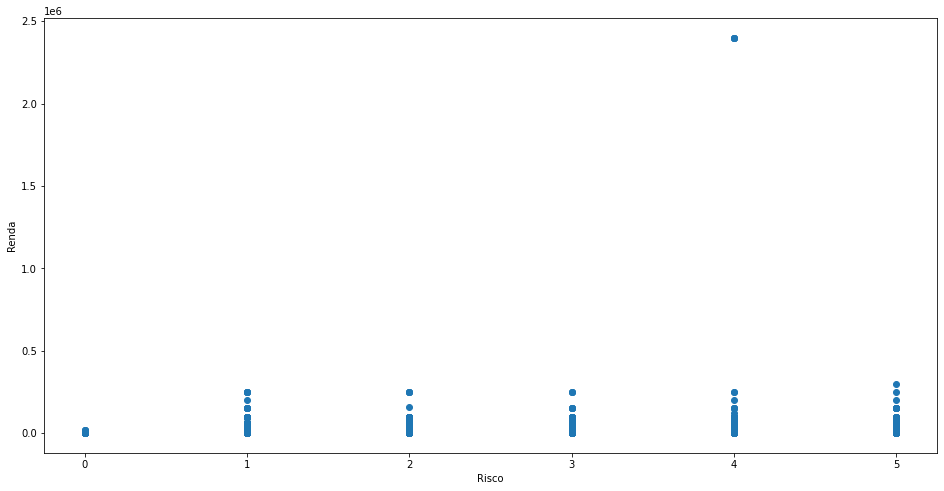

In [ ]:
#Distribuição
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(dfPerfilAnaliseRendaRisco.Risco, dfPerfilAnaliseRendaRisco.RendaMensal)
ax.set_xlabel('Risco')
ax.set_ylabel('Renda')
plt.show()

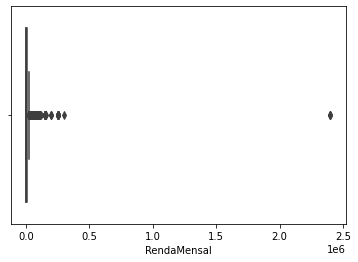

In [ ]:
#Outliers no dataset de renda
sns.boxplot(x=dfPerfilAnaliseRendaRisco.RendaMensal)

In [ ]:
#Remoção dos outliers
removeOutlierByQuartiles(dfPerfilAnaliseRendaRisco, 'RendaMensal')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd1120df7f0>,
      dtype=object)

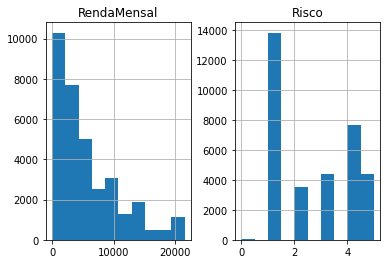

In [ ]:
dfPerfilAnaliseRendaRisco.hist()

###Conclusão
Há grande concentração de salário até 5 mil reais e distribuição equilibrada entre perfil 1, 4 e 5. Desta maneira, não importa o salário para delimitar o perfil de invetidor

#Modelos

## Modelo classificador -> Codinome: Xuxa Recomendation

A ideia desse sistema de recomendação é:


* A partir dos dados de Score (conhecimento, risco, objetivos, situacao financeira) e perfil investidor, determinar o melhor produto

O mapa do modelo é representado abaxo:

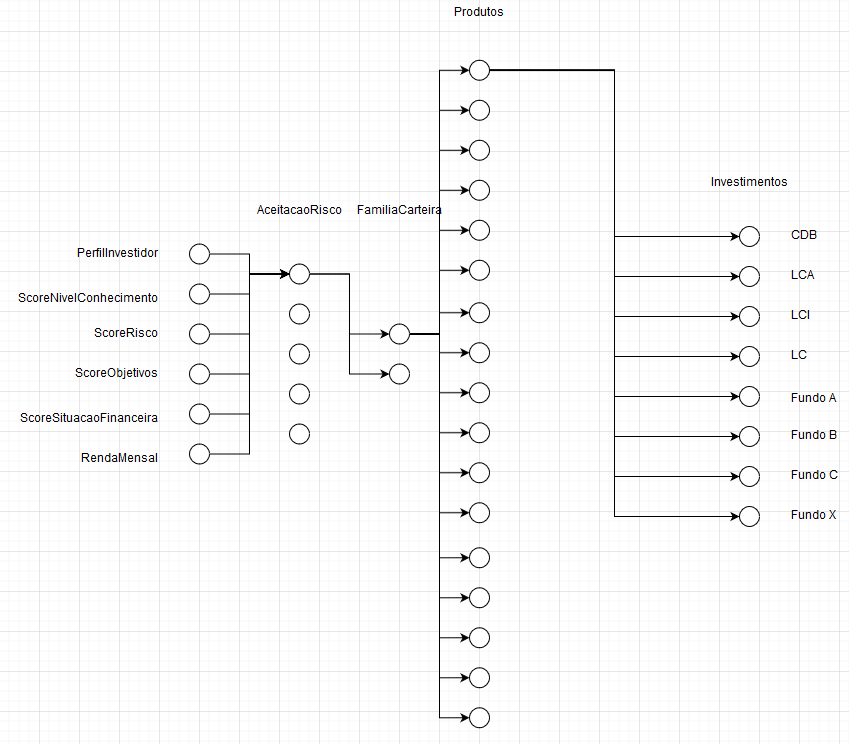

###Setup
Coleta e limpeza de dados de interesse

####Selecionando variáveis - DataSet Perfil

In [ ]:
#Método que verifica registro duplicado por ID no DataSet
#Isso significa quea coluna 'Unnamed: 0' é o ID identificador do investimento para o usuário X que possui identificação  pela coluna 'Id'
pd.concat(g for _, g in dfPerfil.groupby('Id') if len(g) > 1).head(5)

,Unnamed: 0,Id,Idade,EstadoCivil,BillingCity,NivelConhecimentoAtual,ScoreNivelConhecimento,PerfilInvestidor,RendaMensal,ValorPatrimonio,Pergunta1,Resposta11,Pergunta2,Resposta21,Pergunta3,Resposta31,Pergunta4,Resposta41,Pergunta5,Resposta51,Resposta52,Resposta53,Resposta54,Resposta55,Resposta56,Resposta57,Resposta58,Pergunta6,Resposta61,Resposta62,Resposta63,Resposta64,Resposta65,Resposta66,Resposta67,Resposta68,Pergunta7,Resposta71,Resposta72,Resposta73,Resposta74,Resposta75,Pergunta8,Resposta81,Pergunta9,Resposta91,ScoreRisco,ScoreObjetivos,ScoreSituacaoFinanceira,Produto,NomeDoProduto,NomeEmissor,TaxaCliente,TaxaPreCliente,DescricaoProduto,ValorMinimoAplicaInicial,ValorMinimoAplicacaoAdicional,DataVencimento,FamiliaCarteira,ValorInvestidoAtual,ValorRendimento,Rentabilidade12Meses,RentabilidadeMes,RiscoAtivo,Status,ProdutoId
18061,18061,$2b$10$.DCvvJ9WSDpqVP2xXjeSPe..Fx6NhsrK9ZzYadq...,35,C,Juiz de Fora,1.0,1.0,2,2000.0,15000.0,Por quanto tempo você pretende manter seu dinh...,"Não tenho tempo definido, mas busco possibilid...",Quando pensa em investimento o que vem primeir...,Acumular dinheiro com baixo risco,"Dos seus investimentos, qual a necessidade de ...",Até 30%,Agora imagine que você fez um investimento de ...,Resgato parcialmente e invisto este valor em u...,Quais desses produtos você já investiu nos últ...,Poupança,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Quais desses produtos você conseguiria explica...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Agora nos conte como seu dinheiro está distrib...,Poupança,NaN,NaN,NaN,NaN,Quanto da sua renda mensal você consegue guard...,Menor ou igual a 10% da minha renda,Tem alguma formação ou experiência que envolve...,Não tenho,2.0,2.0,1.0,a0W6A000009L0FgUAK,RENATO SANTANIELLO - SANTANDER PRIVATE,NaN,NaN,NaN,RENATO SANTANIELLO - SANTANDER PRIVATE,30.0,30.0,NaN,Renda Fixa,30.0,NaN,0.0,-0.51989985,4.0,Efetivada,a0W6A000009L0FgUAK
18062,18062,$2b$10$.DCvvJ9WSDpqVP2xXjeSPe..Fx6NhsrK9ZzYadq...,35,C,Juiz de Fora,1.0,1.0,2,2000.0,15000.0,Por quanto tempo você pretende manter seu dinh...,"Não tenho tempo definido, mas busco possibilid...",Quando pensa em investimento o que vem primeir...,Acumular dinheiro com baixo risco,"Dos seus investimentos, qual a necessidade de ...",Até 30%,Agora imagine que você fez um investimento de ...,Resgato parcialmente e invisto este valor em u...,Quais desses produtos você já investiu nos últ...,Poupança,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Quais desses produtos você conseguiria explica...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Agora nos conte como seu dinheiro está distrib...,Poupança,NaN,NaN,NaN,NaN,Quanto da sua renda mensal você consegue guard...,Menor ou igual a 10% da minha renda,Tem alguma formação ou experiência que envolve...,Não tenho,2.0,2.0,1.0,a0W6A000009GZdgUAG,PI SELIC RF SIMPLES FI,NaN,NaN,NaN,PI SELIC RF SIMPLES FI,30.0,30.0,NaN,Renda Fixa,30.0,NaN,0.0,0.18808109,1.0,Efetivada,a0W6A000009GZdgUAG
1512,1512,$2b$10$.DCvvJ9WSDpqVP2xXjeSPe./VfMzqzrDosESSEW...,57,C,Maringá,1.0,1.0,1,1950.0,300000.0,Por quanto tempo você pretende manter seu dinh...,De 1 a 5 anos,Quando pensa em investimento o que vem primeir...,Em geral preservar meu dinheiro,"Dos seus investimentos, qual a necessidade de ...",Até 30%,Agora imagine que você fez um investimento de ...,Resgato tudo e invisto em renda fixa,Quais desses produtos você já investiu nos últ...,Poupança,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Quais desses produtos você conseguiria explica...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Agora nos conte como seu dinheiro está distrib...,Poupança,NaN,NaN,NaN,NaN,Quanto da sua renda mensal você consegue guard...,Menor ou igual a 10% da minha renda,Tem alguma formação ou experiência que envolve...,Não tenho,1.0,2.0,1.0,a0W6A000009GZdgUAG,PI SELIC RF SIMPLES FI,NaN,NaN,NaN,NaN,NaN,30.0,NaN,Renda Fixa,50.0,NaN,0.0,0.04210412,1.0,Efetivada,a0W6A000009GZdgUAG
1513,1513,$2b$10$.DCvvJ9WSDpqVP2xXjeSPe./VfMzqzrDosESSEW...,57,C,Maringá,1.0,1.0,1,1950.0,300000.0,Por quanto tempo você pretende manter seu dinh...,De 1 a 5 anos,Quando p

In [5]:
join = pd.merge(dfPerfil, dfProduto[['ProdutoId', 'NomeProduto__c']], left_on='Produto', right_on='ProdutoId', how='inner')
join.head(5)

,Unnamed: 0,Id,Idade,EstadoCivil,BillingCity,NivelConhecimentoAtual,ScoreNivelConhecimento,PerfilInvestidor,RendaMensal,ValorPatrimonio,...,FamiliaCarteira,ValorInvestidoAtual,ValorRendimento,Rentabilidade12Meses,RentabilidadeMes,RiscoAtivo,Status,ProdutoId_x,ProdutoId_y,NomeProduto__c
0,0,$2b$10$.DCvvJ9WSDpqVP2xXjeSPe9yBilu2JVQh2nFTHN...,30,M,Aracruz,1.0,1.0,2,1300.0,6000.0,...,Renda Fixa,30.0,NaN,0.0,0.37005375,1.0,Efetivada,a0W6A000009GZdgUAG,a0W6A000009GZdgUAG,NaN
1,1,$2b$10$.DCvvJ9WSDpqVP2xXjeSPeR6I3TrUCl/MAePvQQ...,25,S,Teresina,1.0,1.0,2,500.0,NaN,...,Renda Fixa,150.0,NaN,0.0,0.05684974,1.0,Efetivada,a0W6A000009GZdgUAG,a0W6A000009GZdgUAG,NaN
2,2,$2b$10$.DCvvJ9WSDpqVP2xXjeSPeR6I3TrUCl/MAePvQQ...,25,S,Teresina,1.0,1.0,2,500.0,NaN,...,Renda Fixa,50.0,NaN,0.0,0.05684974,1.0,Efetivada,a0W6A000009GZdgUAG,a0W6A000009GZdgUAG,NaN
3,3,$2b$10$.DCvvJ9WSDpqVP2xXjeSPeR6I3TrUCl/MAePvQQ...,25,S,Teresina,1.0,1.0,2,500.0,NaN,...,Renda Fixa,60.0,NaN,0.0,0.13178136,1.0,Efetivada,a0W6A000009GZdgUAG,a0W6A000009GZdgUAG,NaN
4,4,$2b$10$.DCvvJ9WSDpqVP2xXjeSPeR6I3TrUCl/MAePvQQ...,25,S,Teresina,1.0,1.0,2,500.0,NaN,...,Renda Fixa,40.0,NaN,0.0,0.15076414,1.0,Efetivada,a0W6A000009GZdgUAG,a0W6A000009GZdgUAG,NaN


In [6]:
#Junção de DFs de interesse
join = pd.merge(dfPerfil, dfProduto[['ProdutoId', 'NomeProduto__c']], left_on='Produto', right_on='ProdutoId', how='inner')

#Gerando DataSet Perfil com apenas as variáveis que indicariam alguma classificação
dfPerfilInteresse = pd.DataFrame(
      {
          'PerfilInvestidor': join['PerfilInvestidor']
          , 'ScoreNivelConhecimento': join['ScoreNivelConhecimento']
          , 'ScoreRisco': join['ScoreRisco']
          , 'ScoreObjetivos': join['ScoreObjetivos']
          , 'ScoreSituacaoFinanceira': join['ScoreSituacaoFinanceira']
          #, 'RendaMensal': dfPerfil['RendaMensal'] #Ainda há dúvidas se é utlizável
          , 'ProdutoID': join['NomeDoProduto']                  
          #, 'ProdutoID': join['NomeProduto__c']       
      })

In [8]:
#Descrevendo o novo data set de interesse
dfPerfilInteresse.describe()

,PerfilInvestidor,ScoreNivelConhecimento,ScoreRisco,ScoreObjetivos,ScoreSituacaoFinanceira
count,36483.000000,36478.000000,36478.000000,36478.000000,36478.000000
mean,2.835512,2.557350,2.682466,3.156231,2.135314
std,1.080879,1.541056,1.110293,1.177186,1.013575
min,0.000000,1.000000,1.000000,1.000000,1.000000
25%,2.000000,1.000000,2.000000,2.000000,1.000000
50%,3.000000,2.000000,3.000000,3.000000,2.000000
75%,4.000000,4.000000,3.000000,4.000000,3.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000


####Tratamendo do dataset de interesse

In [13]:
#Removendo os valores NaN
dfPerfilInteresse.dropna(inplace=True)

In [14]:
#DataSet equilibrado de acordo com o descrivo
dfPerfilInteresse.describe()

,PerfilInvestidor,ScoreNivelConhecimento,ScoreRisco,ScoreObjetivos,ScoreSituacaoFinanceira
count,36468.000000,36468.000000,36468.000000,36468.000000,36468.000000
mean,2.836542,2.557365,2.682708,3.156329,2.135379
std,1.079867,1.541173,1.110156,1.177198,1.013532
min,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.000000,1.000000,2.000000,2.000000,1.000000
50%,3.000000,2.000000,3.000000,3.000000,2.000000
75%,4.000000,4.000000,3.000000,4.000000,3.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000


In [215]:
#Verificando outliers das colunas PerfilInvestidos
#Previsto valores 1 a 5
dfPerfilInteresse.PerfilInvestidor.unique()

array([2, 3, 4, 5, 1, 0])

In [15]:
#Removendo valore com PerfilInvestido 0
#Esse perfil não está no app
dfPerfilInteresse.drop(index=dfPerfilInteresse[dfPerfilInteresse.PerfilInvestidor == 0].index, inplace=True)

In [217]:
#Verificando ScoreNivelConhecimento
dfPerfilInteresse.ScoreNivelConhecimento.unique()


array([1., 2., 4., 3., 5.])

In [ ]:
#Verificando ScoreRisco
dfPerfilInteresse.ScoreRisco.unique()

array([2., 3., 4., 1., 5.])

In [ ]:
#Verificando ScoreObjetivos
dfPerfilInteresse.ScoreObjetivos.unique()

array([2., 3., 1., 5., 4.])

In [ ]:
#Verificando ScoreSituacaoFinanceira
dfPerfilInteresse.ScoreSituacaoFinanceira.unique()

array([1., 2., 3., 5., 4.])

In [236]:
#Verificando FamiliaCarteira
dfPerfilInteresse.ProdutoID.isna().sum()

0

####Balanceamento do DataSet

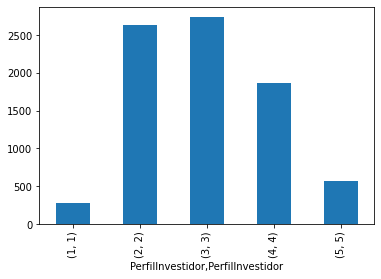

In [220]:
groups = dfPerfilInteresse.groupby('PerfilInvestidor')['PerfilInvestidor'].value_counts()
groups.plot.bar()

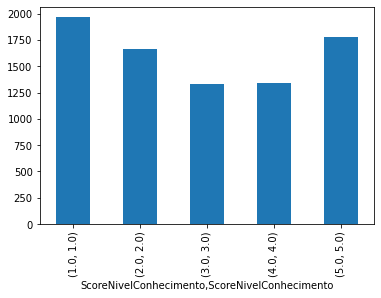

In [221]:
groups = dfPerfilInteresse.groupby('ScoreNivelConhecimento')['ScoreNivelConhecimento'].value_counts()
groups.plot.bar()

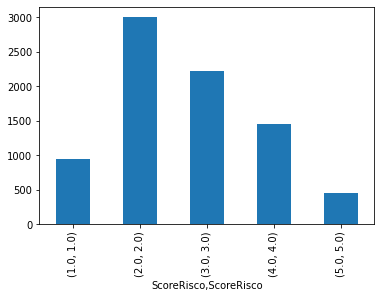

In [222]:
groups = dfPerfilInteresse.groupby('ScoreRisco')['ScoreRisco'].value_counts()
groups.plot.bar()

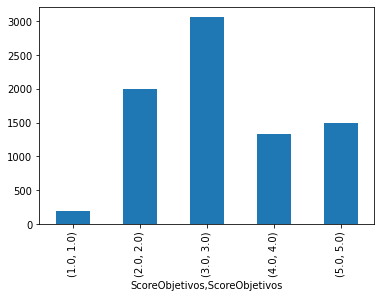

In [223]:
groups = dfPerfilInteresse.groupby('ScoreObjetivos')['ScoreObjetivos'].value_counts()
groups.plot.bar()

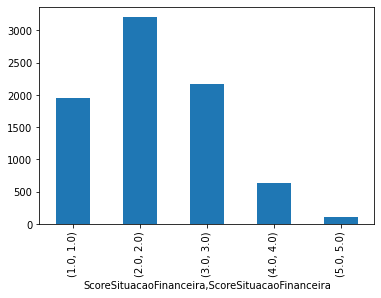

In [224]:
groups = dfPerfilInteresse.groupby('ScoreSituacaoFinanceira')['ScoreSituacaoFinanceira'].value_counts()
groups.plot.bar()

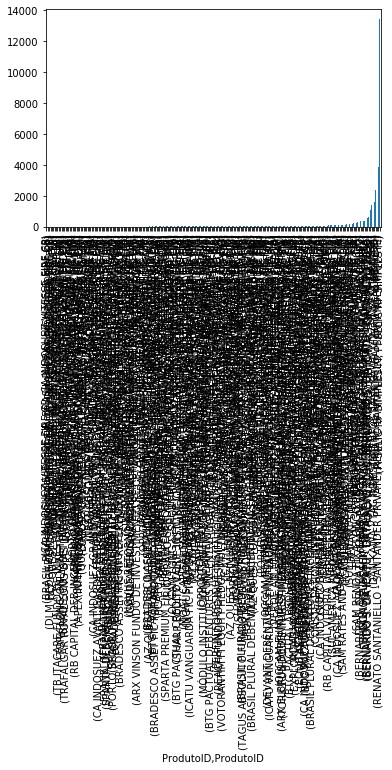

In [132]:
groups = dfPerfilInteresse.groupby('ProdutoID')['ProdutoID'].value_counts().sort_values()
groups.plot.bar()

####Preparando dataset para o modelo - 1.0

In [16]:
#Configurando variáveis categóricas
familiaCarteira = {'Renda Fixa': 0, 'Renda Variável': 1}
dfModelo = dfPerfilInteresse.copy()

#Transformando produtos em One Hot Encoded
dict_produtos = pd.DataFrame(dfModelo.ProdutoID.apply(lambda produto: produto.lower()).unique()).to_dict()[0]
dict_produto_one_hot_enconded = {}
productsEncoded = tf.keras.utils.to_categorical(np.array(list(dict_produtos.keys())), len(dict_produtos))
for dictProdutoKey in dict_produtos.keys():
  dict_produto_one_hot_enconded[dictProdutoKey] = productsEncoded[dictProdutoKey]

#dfModelo.ProdutoID = dfModelo.ProdutoID.apply(lambda produto: getOneHotEncodedByProdutcName(dict_produtos, dict_produto_one_hot_enconded, produto))
dfModelo.ProdutoID = dfModelo.ProdutoID.apply(lambda produto: getProdutoId(dict_produtos, produto))

#Testes
dfModelo.PerfilInvestidor = dfModelo.PerfilInvestidor / 255
dfModelo.ScoreNivelConhecimento = dfModelo.ScoreNivelConhecimento / 255
dfModelo.ScoreRisco = dfModelo.ScoreRisco / 255
dfModelo.ScoreObjetivos = dfModelo.ScoreObjetivos / 255
dfModelo.ScoreSituacaoFinanceira = dfModelo.ScoreSituacaoFinanceira / 255

#Separando Treino e teste
msk = np.random.rand(len(dfModelo)) < 0.7

df_treino = dfModelo[msk]
df_teste  =  dfModelo[~msk]

x_train = df_treino.loc[:, df_treino.columns != 'ProdutoID']
y_train = df_treino['ProdutoID']
x_test = df_teste.loc[:, df_teste.columns != 'ProdutoID']
y_test = df_teste['ProdutoID']

#x_train, x_test = x_train / 255.0, x_test / 255.0

In [76]:
dfModelo.describe()

,PerfilInvestidor,ScoreNivelConhecimento,ScoreRisco,ScoreObjetivos,ScoreSituacaoFinanceira,ProdutoID
count,36468.000000,36468.000000,36468.000000,36468.000000,36468.000000,36468.000000
mean,0.011124,0.010029,0.010520,0.012378,0.008374,12.978694
std,0.004235,0.006044,0.004354,0.004616,0.003975,28.919817
min,0.003922,0.003922,0.003922,0.003922,0.003922,0.000000
25%,0.007843,0.003922,0.007843,0.007843,0.003922,0.000000
50%,0.011765,0.007843,0.011765,0.011765,0.007843,3.000000
75%,0.015686,0.015686,0.011765,0.015686,0.011765,9.000000
max,0.019608,0.019608,0.019608,0.019608,0.019608,242.000000


####Preparando dataset para o modelo - 2.0

####Desenhando o modelo

In [61]:
#Desenhando o modelo 1.0

model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=x_train.shape[1], name='perfil'), #Entradas
    tf.keras.layers.Dense(5, activation='relu', name='aceitacao'), #Aceitaao (1 a 5)
    tf.keras.layers.Dense(2, activation='relu', name='familia_carteira'), #FamiliaCarteira (Renda Fixa e Renda Variavel) 
    tf.keras.layers.Dense(17, activation='relu', name='tipo_produto'), #TipoProduto (17 produtos)
    tf.keras.layers.Dense(len(dict_produtos), activation='softmax', name='investimentos') #Investimentos
], name='xuxa_model')

opt = tf.keras.optimizers.Adagrad(learning_rate=0.0001)
#1 'sparse_categorical_crossentropy'
#lss = tf.keras.losses.kld
lss = tf.keras.losses.sparse_categorical_crossentropy

model.compile(optimizer=opt, loss=lss, metrics=['accuracy'])

removeHistory = False
trainingName = datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "_Adagrad_V2"

if (removeHistory):
    !rm -rf ./logs/ 

log_dir = "logs/fit/" + trainingName
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


model.summary()

Model: "xuxa_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
aceitacao (Dense)            (None, 5)                 30        
_________________________________________________________________
familia_carteira (Dense)     (None, 2)                 12        
_________________________________________________________________
tipo_produto (Dense)         (None, 17)                51        
_________________________________________________________________
investimentos (Dense)        (None, 243)               4374      
Total params: 4,467
Trainable params: 4,467
Non-trainable params: 0
_________________________________________________________________


####Treinamento

In [62]:
# Treinamento do modelo
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=1000, batch_size=8, shuffle=True, callbacks=[tensorboard_callback], verbose=False)

####Qualidade do modelo

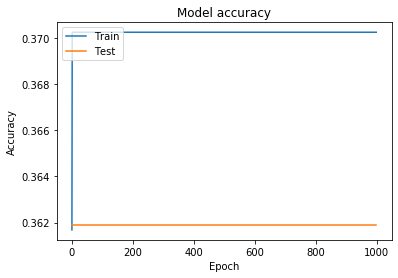

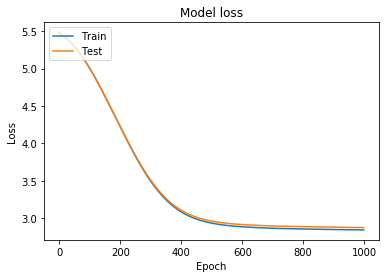

In [63]:
#Avaliando treinamento
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

####Teste manual

In [118]:
#Pos1 = PerfilInvestidor (1 a 5)
pos1 = 1
#Pos2 = ScoreConhecimento (1 a 5)
pos2 = 1
#Pos3 = ScoreRisco (1 a 5)
pos3 = 1
#Pos4 = ScoreObjetivos (1 a 5)
pos4 = 1
#Pos5 = ScoreSituacaoFinanceira (1 a 5)
pos5 = 1

inputData = [[pos1, pos2, pos3, pos4, pos5]]

#inputDados['pos1'] = pos1
#inputDados['pos2'] = pos2
#inputDados['pos3'] = pos3
#inputDados['pos4'] = pos4
#inputDados['pos5'] = pos5

#TratamentoDadps
fixedData = pd.DataFrame(inputData) / 255

#Predizendo top 10 investimentos
modelResult = model.predict(fixedData)

#Filtrando apenas resultados relevantes (top 10)
modelResultFixed = pd.DataFrame(modelResult)
modelResultFixed = modelResultFixed.transpose()[0]
investments = pd.DataFrame()
investments['Investimentos'] = modelResultFixed * 100
investments = investments.sort_values(by=['Investimentos'], ascending=False)
investments.head(10)

,Investimentos
0,37.235542
3,10.543743
8,6.142413
2,5.983172
9,4.055281
6,3.814686
12,3.634522
1,2.405216
23,1.264541
7,1.031212


In [111]:
dict_produtos

{0: 'pi selic rf simples fi',
 1: 'jojo wachsmann - vitreo',
 2: 'sam juro real rf fic fi',
 3: 'renato santaniello - santander private',
 4: 'sam renda fixa longo prazo fic fi',
 5: 'fabio passos - ca indosuez',
 6: 'dan kawa - tag investimentos',
 7: 'bernardo s. da icatu - data alvo 2030',
 8: 'cdb',
 9: 'lca',
 10: 'trigono flagship small caps fic fia',
 11: 'bogari value d fic fia',
 12: 'lci',
 13: 'bernardo s. da icatu - data alvo 2040',
 14: 'btg pactual yield di fi referenciado cp',
 15: 'alaska black fic fia ii - bdr nível i',
 16: 'icatu vanguarda cp firf lp',
 17: 'sam rates and fx multimercado fic fi',
 18: 'sul américa fv fia',
 19: 'lc',
 20: 'nest fia',
 21: 'kadima equities fic fia',
 22: 'constância fundamento fia',
 23: 'bernardo s. da icatu - data alvo 2050',
 24: 'arx income fia',
 25: 'equitas selection fic fia',
 26: 'equitas selection mão amiga fic ações',
 27: 'az quest yield fic firf lp',
 28: 'arx fia',
 29: 'ibiuna equities 30 fic fia',
 30: 'kapitalo kappa 